# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/Zakaria-Yahya/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 81 (delta 23), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 312.73 KiB | 15.64 MiB/s, done.
Resolving deltas: 100% (23/23), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


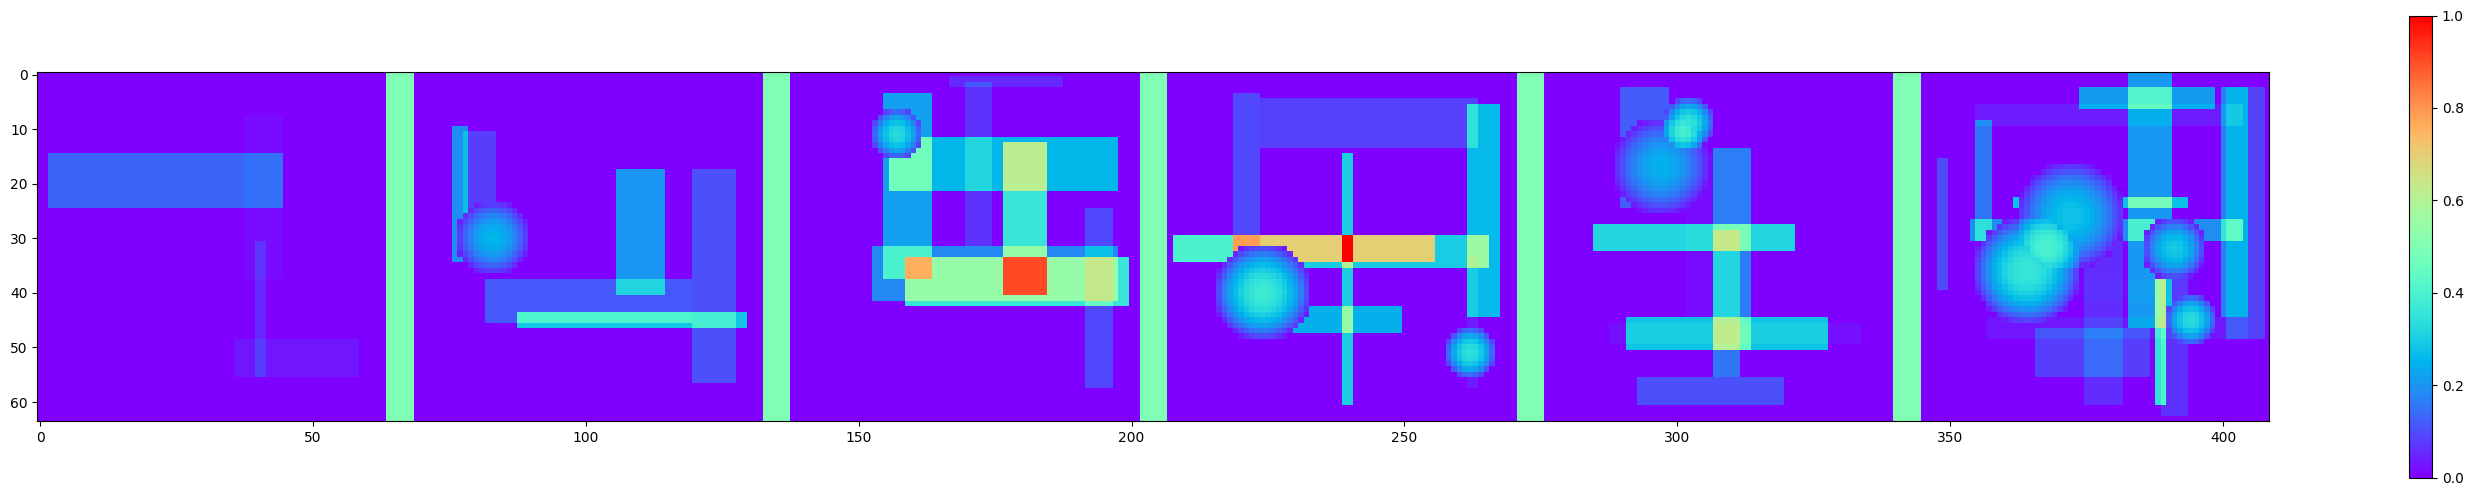

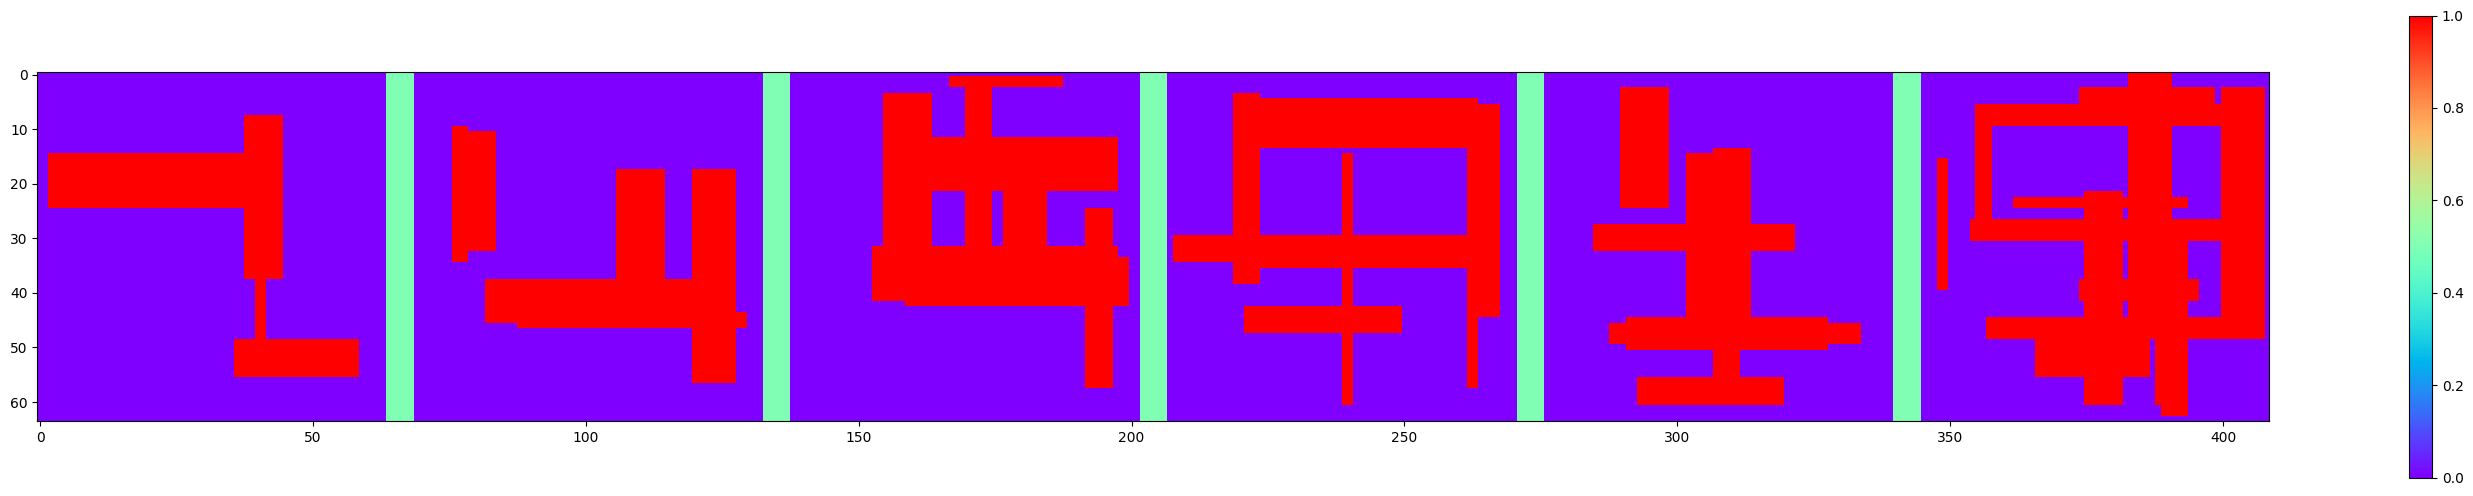

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

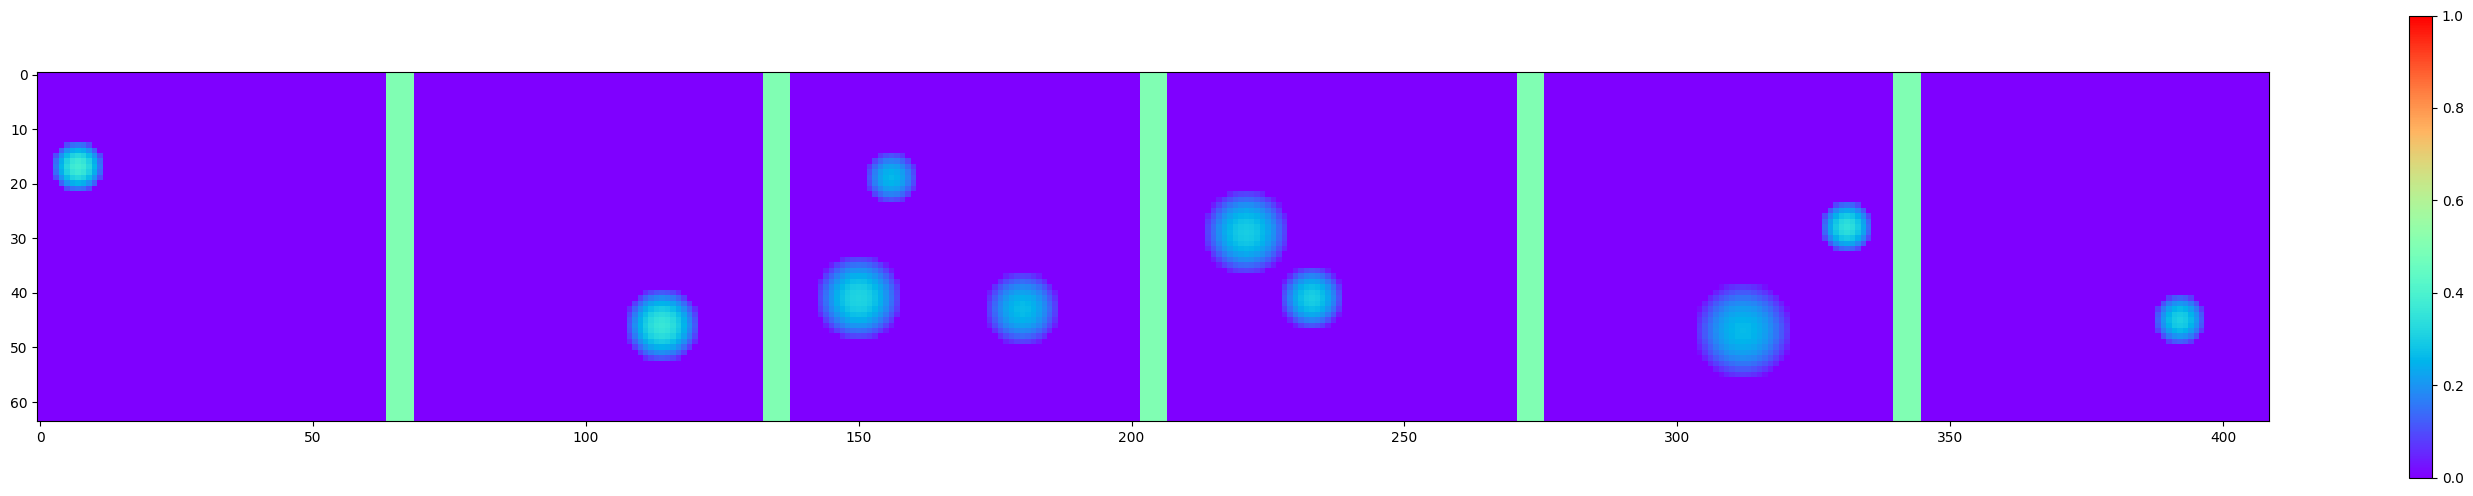

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

**Reponse:**
Supervision faible est quand le modèle est entraîné avec des données partiellement étiquetées.
Ce problème est considéré comme de la supervision faible car nous n'avons pas les cibles idéales pour toutes les images. On a seulement des images cibles pour un sous-ensemble des données d'entraînement. On doit donc utiliser une forme de supervision faible pour que le modèle puisse prédire l'emplacement des pixels de rectangles avant la corruption sur de nouvelles images.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

<ipython-input-32-528128b4a7ff>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).squeeze(2)  # Ajout d'une dimension de canal
<ipython-input-32-528128b4a7ff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(ideal_targets, dtype=torch.float32).unsqueeze(1).squeeze(2)


Epoch 0/50, Loss: 0.7386
Epoch 10/50, Loss: 0.2395
Epoch 20/50, Loss: 0.1591
Epoch 30/50, Loss: 0.1149
Epoch 40/50, Loss: 0.0866


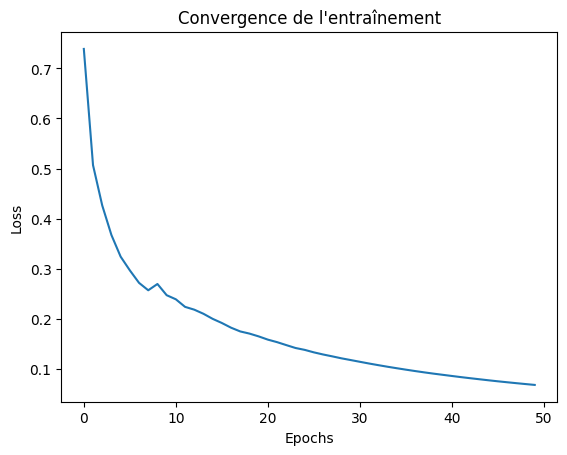

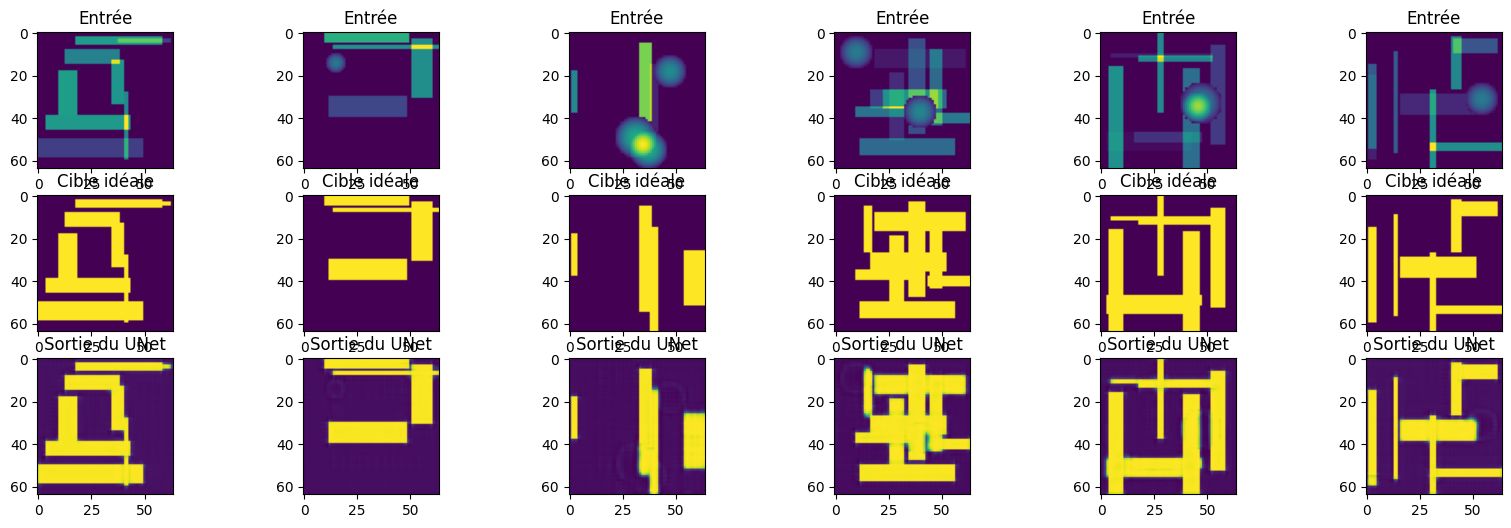

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def train_unet(n_epochs=50, batch_size=6, lr=0.001):
    # Génération des données d'entraînement
    inputs, ideal_targets = gen_dr(batch_size)

    # Conversion en tenseurs PyTorch
    inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).squeeze(2)  # Ajout d'une dimension de canal
    targets = torch.tensor(ideal_targets, dtype=torch.float32).unsqueeze(1).squeeze(2)

    # Définition du modèle, de la fonction de perte et de l'optimiseur
    model = UNet(n_channels=1, n_classes=1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    # Entraînement
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.4f}")

    # Visualisation de la perte
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Convergence de l'entraînement")
    plt.show()

    # Visualisation des résultats
    outputs = torch.sigmoid(model(inputs)).detach().numpy()

    fig, axes = plt.subplots(3, batch_size, figsize=(20, 6))
    for i in range(batch_size):
        axes[0, i].imshow(inputs[i, 0])
        axes[0, i].set_title("Entrée")

        axes[1, i].imshow(targets[i, 0])
        axes[1, i].set_title("Cible idéale")

        axes[2, i].imshow(outputs[i, 0])
        axes[2, i].set_title("Sortie du UNet")

    plt.show()
    return model

# Entraînement du modèle
model = train_unet()




\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([5.4084, 3.4288, 8.8607, 4.4704, 4.0286, 6.3761])


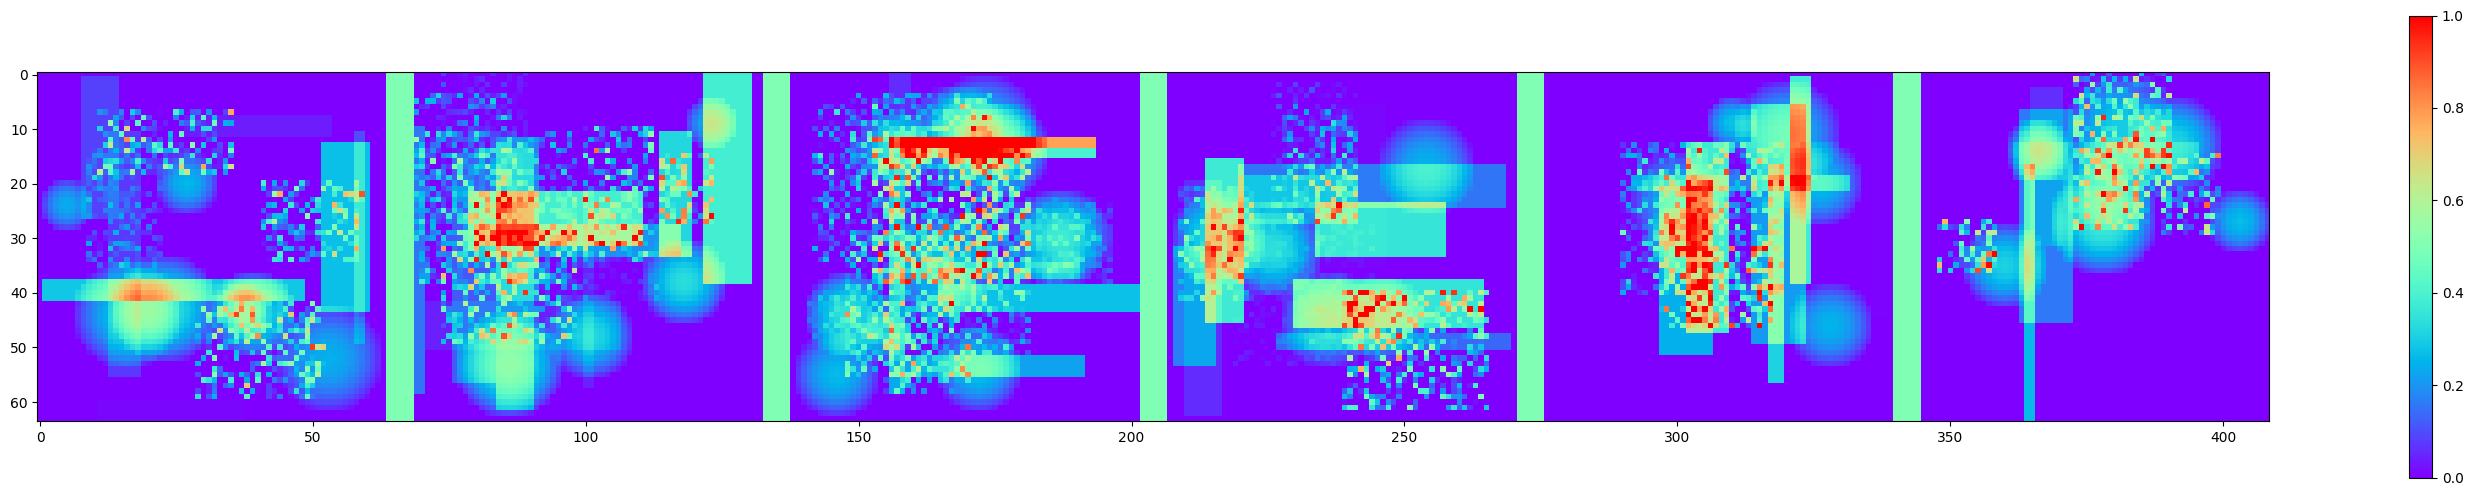

tensor([5.5606, 4.2864, 9.1560, 5.3006, 3.8157, 5.9230])


In [35]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

In [36]:
# Créer un Dataset PyTorch
dataset = TensorDataset(inputs, targets)

# Créer un DataLoader avec 2 workers
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

tensor([3.2324, 1.9278, 5.2017,  ..., 0.0000, 2.8159, 5.4708])


<ipython-input-41-4aed6253cb70>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1)  # Ajouter un canal
<ipython-input-41-4aed6253cb70>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)  # Pour la régression
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weigh

Époque 1/20, Perte : 8.5598
Époque 2/20, Perte : 3.1104
Époque 3/20, Perte : 1.8930
Époque 4/20, Perte : 1.4153
Époque 5/20, Perte : 0.9469
Époque 6/20, Perte : 1.0037
Époque 7/20, Perte : 0.7970
Époque 8/20, Perte : 0.6852
Époque 9/20, Perte : 0.6398
Époque 10/20, Perte : 0.6355
Époque 11/20, Perte : 0.6162
Époque 12/20, Perte : 0.4862
Époque 13/20, Perte : 0.4970
Époque 14/20, Perte : 0.4123
Époque 15/20, Perte : 0.3969
Époque 16/20, Perte : 0.3337
Époque 17/20, Perte : 0.3924
Époque 18/20, Perte : 0.3803
Époque 19/20, Perte : 0.3852
Époque 20/20, Perte : 0.5305


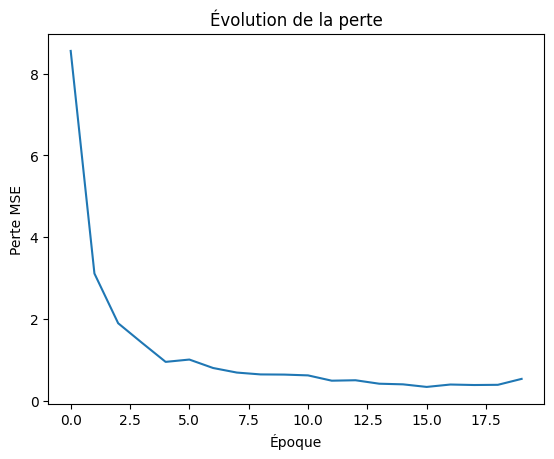

In [41]:

from torchvision.models import resnet18


# Générer les données
inputs, targets = gen_ex2(1024)  # 1024 échantillons pour l'entraînement
inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1)  # Ajouter un canal
targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)  # Pour la régression

# Création du DataLoader
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# Charger ResNet18 pré-entraîné et adapter pour la régression
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Prédiction d'une seule valeur (médiane)

# Définir la perte et l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement
num_epochs = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()
        batch_inputs = batch_inputs.squeeze(2)
        outputs = model(batch_inputs.repeat(1, 3, 1, 1))  # ResNet attend 3 canaux
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(dataloader))
    print(f"Époque {epoch+1}/{num_epochs}, Perte : {losses[-1]:.4f}")

# Affichage de la courbe de perte
plt.plot(losses)
plt.xlabel("Époque")
plt.ylabel("Perte MSE")
plt.title("Évolution de la perte")
plt.show()





**Justification de l'absence de l'étape de validation:** gen_ex2() génère des données aléatoires à chaque appel, donc les données sont infinies. Il est inutile d’avoir une validation classique, car chaque batch est différent.

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

In [46]:
# Charger un ResNet18 pré-entraîné
model = resnet18(pretrained=True)

# Modifier la couche de classification pour prédire 3 valeurs (Q1, médiane, Q3)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3) # 3 sorties pour Q1, médiane, Q3
def quantile_loss(outputs, targets, quantiles):
    """
    Calcule la Quantile Loss.

    Args:
        outputs: Tenseur des sorties du modèle (batch_size, num_quantiles).
        targets: Tenseur des valeurs cibles (batch_size, 1).
        quantiles: Liste des quantiles à prédire (e.g., [0.25, 0.5, 0.75]).

    Returns:
        La Quantile Loss.
    """
    loss = 0
    for i, q in enumerate(quantiles):
        errors = targets - outputs[:, i]
        loss += torch.mean(torch.max((q - 1) * errors, q * errors))
    return loss
# Quantiles à prédire
quantiles = [0.25, 0.5, 0.75]

# Boucle d'entraînement
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs  = inputs.unsqueeze(1).squeeze(2)
        ouuputs = outputs.unsqueeze(1).squeeze(2)
        outputs = model(inputs)
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 1, 1, 64, 64]

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

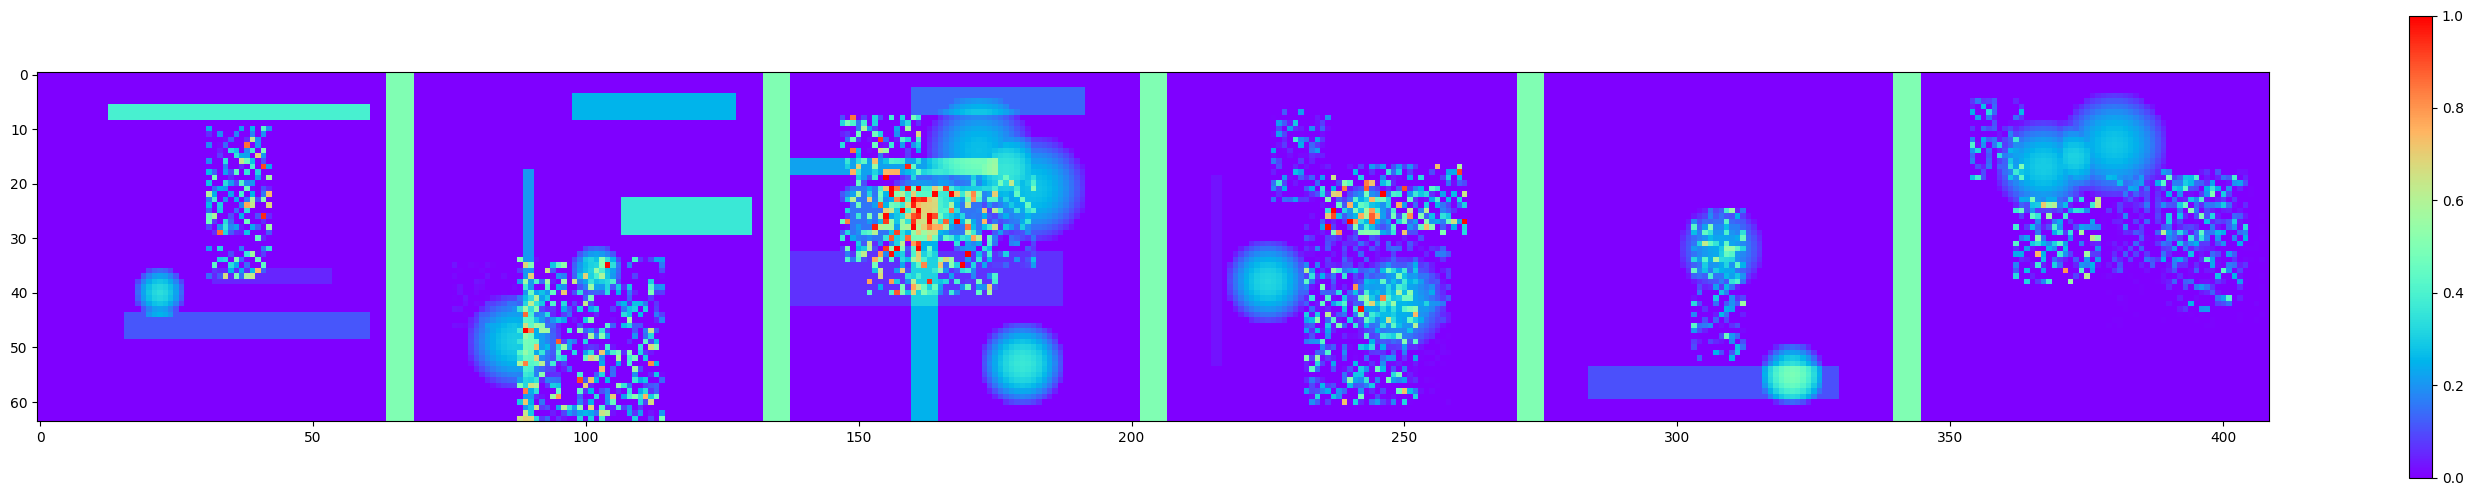

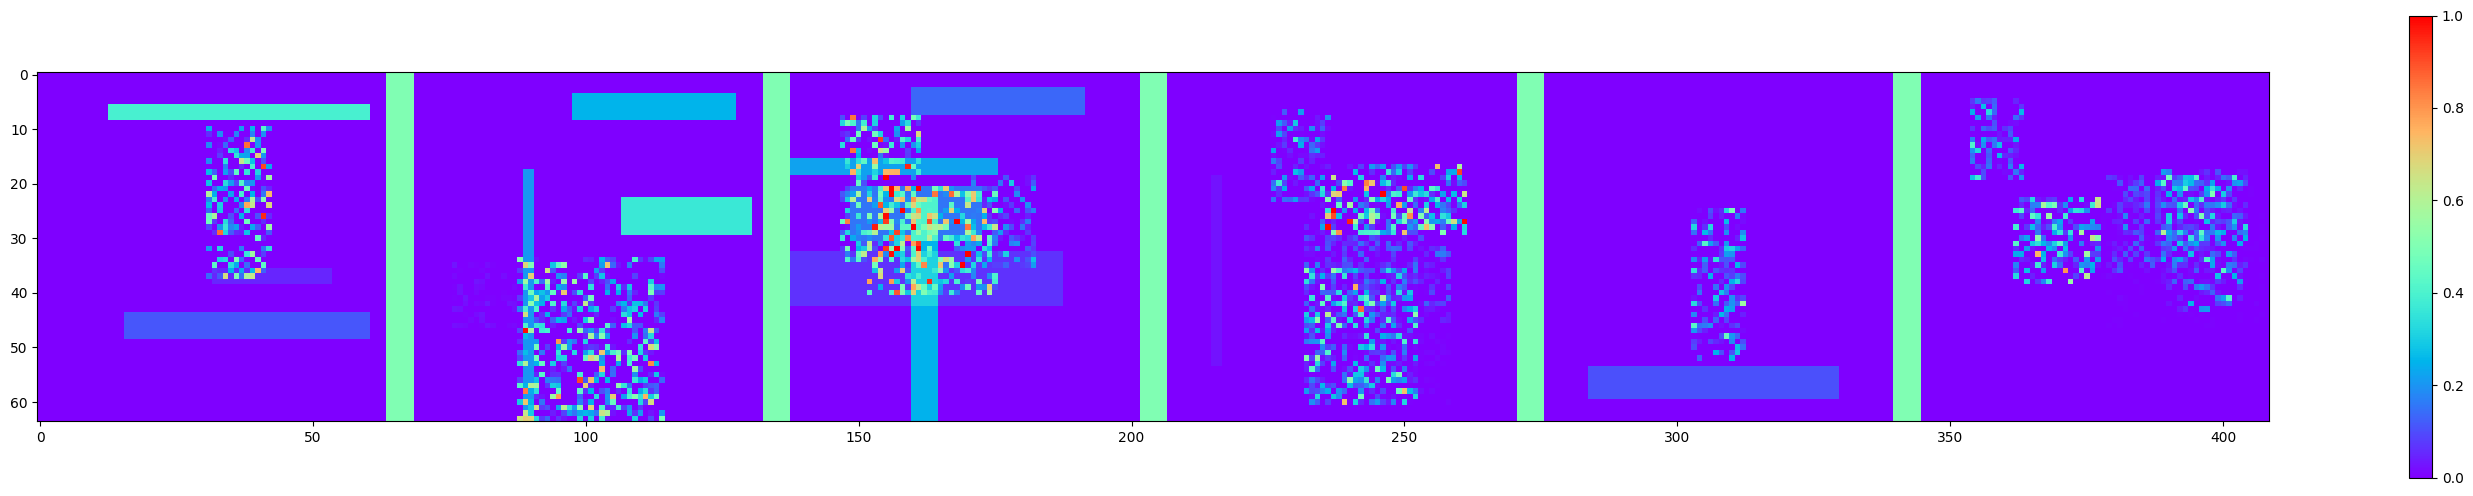

In [47]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

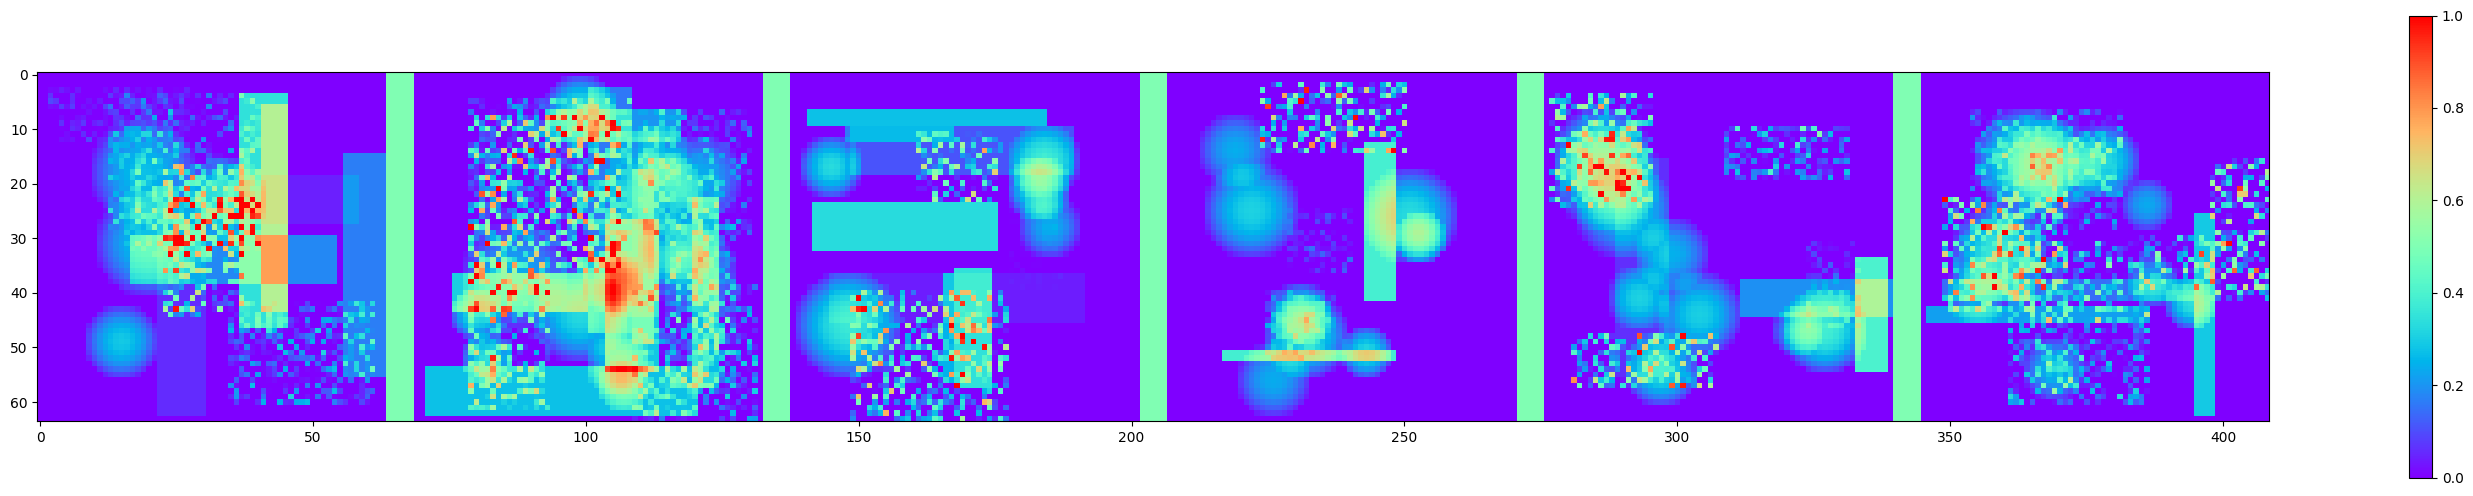

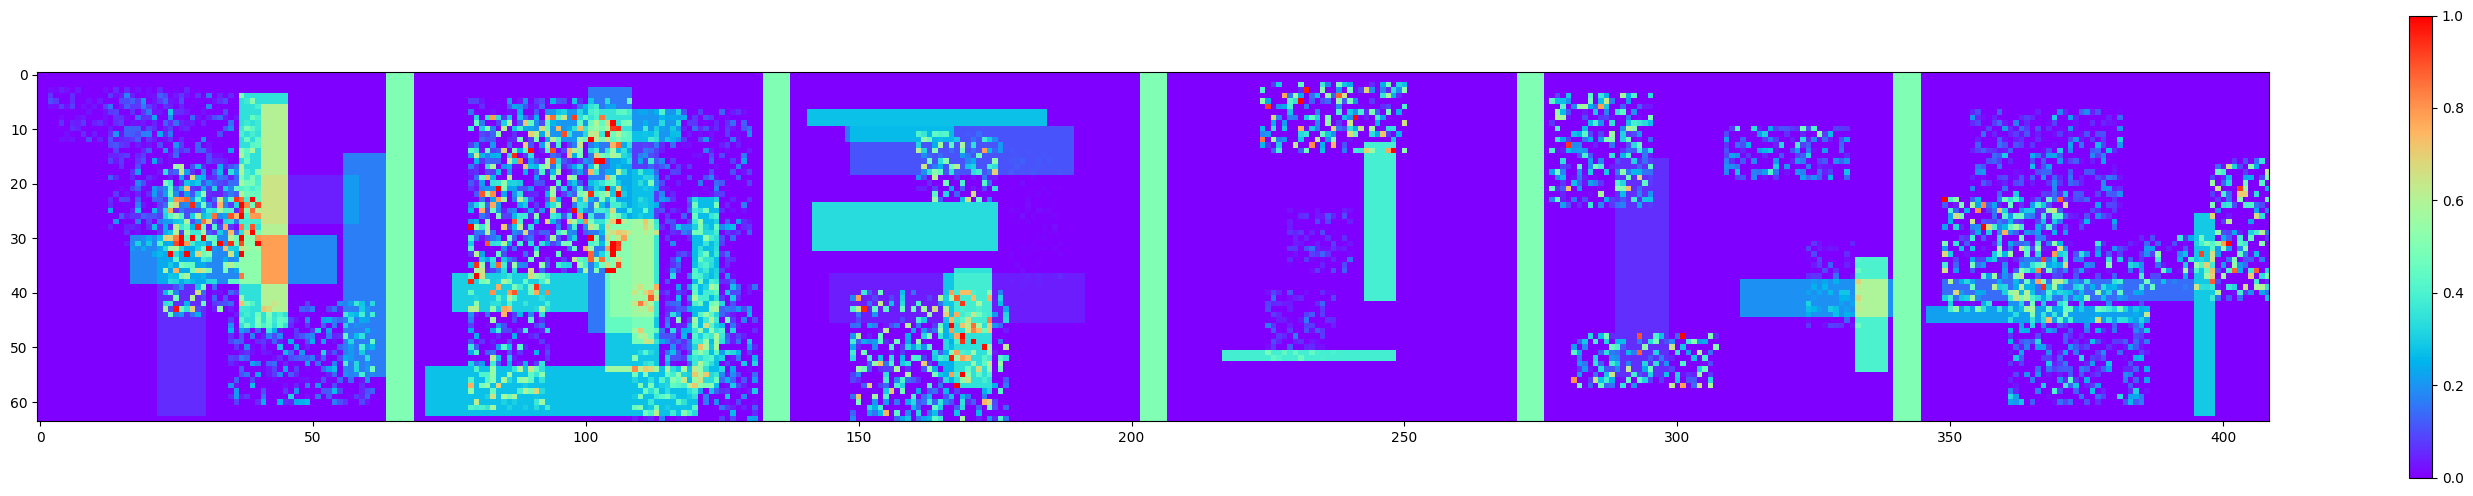

In [48]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

Domain adaptation (adaptation de domaine) est un domaine de l'apprentissage automatique qui vise à améliorer les performances d'un modèle sur un domaine cible (les données sur lesquelles on souhaite appliquer le modèle) lorsque celui-ci a été entraîné sur un domaine source différent (les données d'entraînement disponibles).

Lien avec l'énoncé : L'exercice 3 présente un cas d'adaptation de domaine car les données d'entraînement (gen_dr_train) et de test (gen_dr_test) ont des distributions différentes (images de test plus chargées). L'adaptation est nécessaire pour que le modèle, entraîné sur gen_dr_train, puisse généraliser correctement aux données de test

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

In [62]:
import numpy as np
from sklearn.metrics import accuracy_score

# Paramètres
n_epochs = 30  # Nombre d'époques d'entraînement
batch_size = 32
learning_rate = 0.001

# Fonction pour entraîner un modèle
def train_model(train_data_gen, n_epochs, batch_size, learning_rate):
    """Entraîne un modèle UNet en utilisant la fonction de génération de données spécifiée."""

    # Créer le jeu de données et le chargeur de données
    inputs, targets = train_data_gen(20) # Générer 1000 images pour l'entraînement
    inputs = inputs.unsqueeze(1).squeeze(2)
    targets = targets.unsqueeze(1).squeeze(2)
    dataset = TensorDataset(inputs, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialiser le modèle, l'optimiseur et la fonction de perte
    model = UNet(n_channels=1, n_classes=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()  # Utilisation de BCEWithLogitsLoss

    # Entraînement du modèle
    for epoch in range(n_epochs):
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer.zero_grad()
            data = data.unsqueeze(1).squeeze(2)
            target = target.unsqueeze(1).squeeze(2)
            output = model(data)  # Pas besoin d'ajouter torch.sigmoid()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    return model

# Entraîner le modèle sur gen_dr_train
model_train = train_model(gen_dr_train, n_epochs, batch_size, learning_rate)

# Entraîner le modèle sur gen_dr_test (situation idéale)
model_ideal = train_model(gen_dr_test, n_epochs, batch_size, learning_rate)

# Évaluation des performances sur le jeu de test (gen_dr_test)
inputs_test, targets_test = gen_dr_test(6) # Générer 6 images pour le test

with torch.no_grad():
    outputs_train = model_train(inputs_test)
    outputs_ideal = model_ideal(inputs_test)

# Calcul de l'accuracy
outputs_train = (outputs_train > 0.5).float()
outputs_ideal = (outputs_ideal > 0.5).float()
accuracy_train = accuracy_score(targets_test.cpu().numpy().flatten(), outputs_train.cpu().numpy().flatten())
accuracy_ideal = accuracy_score(targets_test.cpu().numpy().flatten(), outputs_ideal.cpu().numpy().flatten())

print(f"Accuracy (entraîné sur gen_dr_train): {accuracy_train:.4f}")
print(f"Accuracy (situation idéale): {accuracy_ideal:.4f}")

Epoch [1/30], Loss: 0.6191
Epoch [2/30], Loss: 0.5465
Epoch [3/30], Loss: 0.4966
Epoch [4/30], Loss: 0.4621
Epoch [5/30], Loss: 0.4321
Epoch [6/30], Loss: 0.4067
Epoch [7/30], Loss: 0.3861
Epoch [8/30], Loss: 0.3687
Epoch [9/30], Loss: 0.3553
Epoch [10/30], Loss: 0.3423
Epoch [11/30], Loss: 0.3312
Epoch [12/30], Loss: 0.3208
Epoch [13/30], Loss: 0.3104
Epoch [14/30], Loss: 0.3010
Epoch [15/30], Loss: 0.2916
Epoch [16/30], Loss: 0.2836
Epoch [17/30], Loss: 0.2761
Epoch [18/30], Loss: 0.2691
Epoch [19/30], Loss: 0.2625
Epoch [20/30], Loss: 0.2560
Epoch [21/30], Loss: 0.2495
Epoch [22/30], Loss: 0.2442
Epoch [23/30], Loss: 0.2392
Epoch [24/30], Loss: 0.2345
Epoch [25/30], Loss: 0.2300
Epoch [26/30], Loss: 0.2257
Epoch [27/30], Loss: 0.2214
Epoch [28/30], Loss: 0.2175
Epoch [29/30], Loss: 0.2139
Epoch [30/30], Loss: 0.2105
Epoch [1/30], Loss: 0.7374
Epoch [2/30], Loss: 0.6729
Epoch [3/30], Loss: 0.6213
Epoch [4/30], Loss: 0.5732
Epoch [5/30], Loss: 0.5371
Epoch [6/30], Loss: 0.5058
Epoch [

ValueError: Classification metrics can't handle a mix of continuous and binary targets

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).

**Reponse:**
- Il s'agit d'un problème de segmentation sémantique où chaque pixel d'une image doit être classé en fonction de sa catégorie.
- Les méthodes d'augementation de données utilisées sont : Les déformations élastiques aléatoires, les décalages et les rotations aléatoires, les variations des niveaux de gris et le Dropout.
- Le déséquilibre des classes provient du fait que, dans les images biomédicales, certaines structures (par exemple, les membranes cellulaires) occupent une proportion bien plus faible que les autres régions (cytoplasme, fond, etc.).